In [ ]:
import json
import pandas as pd
import openai
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_path = "../data/train.jsonl"

In [14]:
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

In [15]:
# 🔹 Filter: "VERIFIABLE" claims & "SUPPORTS"/"REFUTES" labels
df_filtered = df[(df["verifiable"] == "VERIFIABLE") & (df["label"].isin(["SUPPORTS", "REFUTES"]))].copy()
df_filtered = df_filtered[["claim", "label"]].head(200)
print("\n=== Label Distribution in First 200 Rows ===")
print(df_filtered['label'].value_counts())


=== Label Distribution in First 200 Rows ===
label
SUPPORTS    146
REFUTES      54
Name: count, dtype: int64


In [16]:
def classify_claim(claim_text, model="gpt-4-turbo"):
    """Calls OpenAI API to classify a claim as SUPPORTS or REFUTES."""
    if not isinstance(claim_text, str) or claim_text.strip() == "":
        return None  # Avoid empty inputs
    
    prompt = f"""
    Determine whether the following claim is "SUPPORTS" or "REFUTES".
    Provide only "SUPPORTS" or "REFUTES" as the output.
    
    Claim:
    {claim_text}
    """

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "system", "content": "You are a fact-checking AI."},
                      {"role": "user", "content": prompt}],
            temperature=0
        )
        prediction = response.choices[0].message.content.strip().upper()
        return prediction if prediction in ["SUPPORTS", "REFUTES"] else None
    except Exception as e:
        print(f"Error processing claim: {e}")
        return None

In [ ]:
# 🔹 Run Classification on First 200 Rows
df_filtered["LLM_Prediction"] = df_filtered["claim"].apply(classify_claim)

# 🔹 Remove rows where LLM didn't return a valid prediction
df_filtered.dropna(subset=["LLM_Prediction"], inplace=True)

# 🔹 Convert Labels to Match
df_filtered["label"] = df_filtered["label"].str.upper()
df_filtered["LLM_Prediction"] = df_filtered["LLM_Prediction"].str.upper()

# 🔹 Save results to CSV
output_file = "llm_predictions_200rows.csv"
df_filtered.to_csv(output_file, index=False, encoding="utf-8")
print(f"\nResults saved to {output_file}")



Results saved to llm_predictions_200rows.csv

=== LLM Model Performance ===
Accuracy: 0.8550
              precision    recall  f1-score   support

     REFUTES       0.67      0.93      0.78        54
    SUPPORTS       0.97      0.83      0.89       146

    accuracy                           0.85       200
   macro avg       0.82      0.88      0.83       200
weighted avg       0.89      0.85      0.86       200



In [4]:
df_filtered = pd.read_csv("../LLM Results/LLM_Predictions_200rows.csv")
df_filtered

,claim,label,LLM_Prediction
0,Nikolaj Coster-Waldau worked with the Fox Broa...,SUPPORTS,SUPPORTS
1,Roman Atwood is a content creator.,SUPPORTS,SUPPORTS
2,"History of art includes architecture, dance, s...",SUPPORTS,SUPPORTS
3,Adrienne Bailon is an accountant.,REFUTES,REFUTES
4,Homeland is an American television spy thrille...,SUPPORTS,SUPPORTS
...,...,...,...
195,Ramayanam was produced by M. S. Reddy and dire...,SUPPORTS,REFUTES
196,Man of Steel features the DC Comics character ...,SUPPORTS,SUPPORTS
197,Leukemia has to do with a lack of normal blood...,SUPPORTS,SUPPORTS
198,Judy Garland did not appear in a courtroom dra...,REFUTES,REFUTES



=== LLM Model Performance ===
Accuracy: 0.85500
              precision    recall  f1-score   support

     REFUTES    0.66667   0.92593   0.77519        54
    SUPPORTS    0.96800   0.82877   0.89299       146

    accuracy                        0.85500       200
   macro avg    0.81733   0.87735   0.83409       200
weighted avg    0.88664   0.85500   0.86118       200



<Figure size 640x480 with 0 Axes>

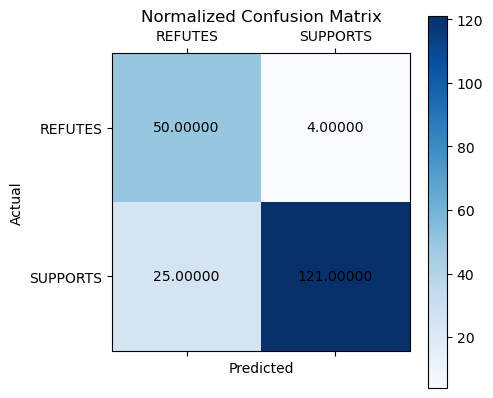

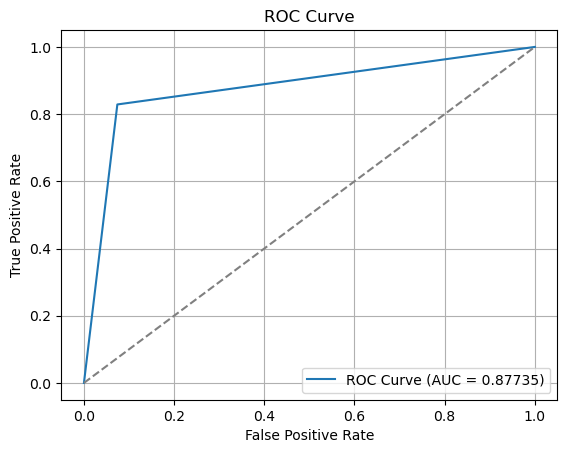

ROC AUC Score: 0.87735


In [19]:
true_labels = df_filtered["label"].values
predicted_labels = df_filtered["LLM_Prediction"].values

# Compute metrics
accuracy = accuracy_score(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=["REFUTES", "SUPPORTS"], digits=5)

print("\n=== LLM Model Performance ===")
print(f"Accuracy: {accuracy:.5f}")
print(report)


# Confusion Matrix (row-wise)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure()
plt.matshow(conf_matrix, cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.xticks([0, 1], ["REFUTES", "SUPPORTS"])
plt.yticks([0, 1], ["REFUTES", "SUPPORTS"])
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{value:.5f}', ha='center', va='center')
plt.grid(False)
plt.show()

# ROC AUC and ROC Curve
roc_auc = roc_auc_score(true_labels, predicted_labels)
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {roc_auc:.5f}")
